# IBM AI Workflow Capstone Part 2 - Model development

In the second part, we train various models for time series prediction and pick out the best model for development.

Here we test out some familiar models for time series predictions, as well as recently released model. The list includes:
- Exponential Moving Average (EMA)
- FB Prophet
- Random Forest
- XGBoost
- LSTM

We'll be testing all these models and pick out the best of the bunch for the third part - Deployment.

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_absolute_error

from application.utils.ingestion import fetch_data,fetch_ts
from application.utils.processing import convert_to_ts, engineer_features
from application.utils.plot import ts_plot, ts_plot_pred

### Load the data

In [2]:
data_dir = os.path.join("data","cs-train")
ts_data = fetch_ts(data_dir)
ts_data

... loading ts data from files


{'all':           date  purchases  unique_invoices  unique_streams  total_views  \
 0   2017-11-28       3223              166            1345        15047   
 1   2017-11-29       3277              133            1397        14159   
 2   2017-11-30       3002              150            1335        15766   
 3   2017-12-01       2559              107            1256        12524   
 4   2017-12-02        402               32             287         3313   
 ..         ...        ...              ...             ...          ...   
 606 2019-07-27          0                0               0            0   
 607 2019-07-28       1271               43             789         7004   
 608 2019-07-29       1200               51             770         7025   
 609 2019-07-30       1369               61             862         8492   
 610 2019-07-31       1560               84             871         9473   
 
     year_month   revenue  
 0      2017-11  14450.54  
 1      2017-11  13411.

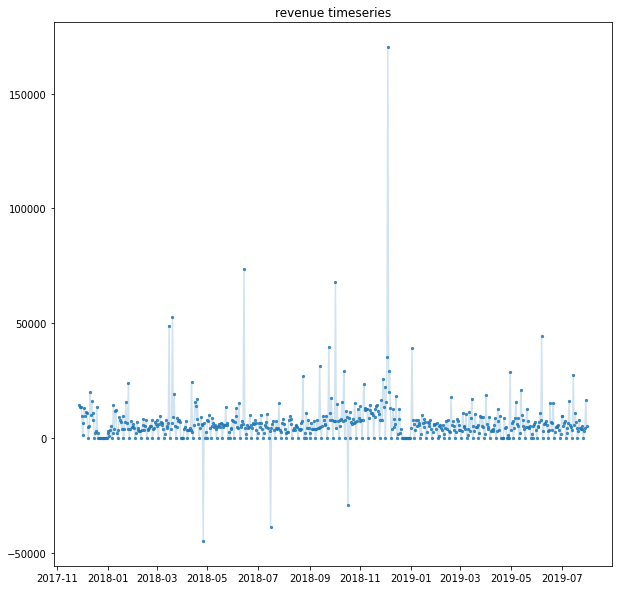

In [3]:
ts_plot(ts_data['all'].date.values, ts_data['all'].revenue.values, title="revenue timeseries")

## 1. Exponential Moving Average

Exponential Moving Average (EMA) is an algorithm that predicts next values using the past. More specifically, it puts more weight on more recent values and less weight on faraway values.

In [4]:
windows = list(range(2, 30))
features = ['all', 'united_kingdom', 'eire', 'germany']
results = []

for window in windows:
    print(f"Window size: {window}")
    mae = []
    
    for feature in features:
        # Retrieve training data and testing data by taking 30 final samples as test set.
        df = ts_data[feature]
        df_train = ts_data[feature][:-30]
        df_test = ts_data[feature][-30:].copy()

        # Exponential moving average to predict the next value.
        df_test['pred'] = df_train['revenue'].ewm(span=window).mean().iloc[-1]
        
        mae.append(mean_absolute_error(df_test.revenue, df_test.pred))

    
    results.append(np.mean(mae))
    print("Average MAE: {}".format(results[-1]))
    

Window size: 2
Average MAE: 2079.845472848009
Window size: 3
Average MAE: 1857.8866974052507
Window size: 4
Average MAE: 1779.4849458624435
Window size: 5
Average MAE: 1755.1450007141748
Window size: 6
Average MAE: 1746.0089177179743
Window size: 7
Average MAE: 1742.2964033845192
Window size: 8
Average MAE: 1740.7690563822628
Window size: 9
Average MAE: 1740.4429630297736
Window size: 10
Average MAE: 1740.5912837381213
Window size: 11
Average MAE: 1741.664894598881
Window size: 12
Average MAE: 1743.765779205905
Window size: 13
Average MAE: 1745.833533345376
Window size: 14
Average MAE: 1747.7734315509197
Window size: 15
Average MAE: 1750.4731832609175
Window size: 16
Average MAE: 1753.68878363384
Window size: 17
Average MAE: 1756.647034304497
Window size: 18
Average MAE: 1759.4719865850132
Window size: 19
Average MAE: 1762.6521608039982
Window size: 20
Average MAE: 1765.5226527266461
Window size: 21
Average MAE: 1768.1051262608144
Window size: 22
Average MAE: 1770.4215242299422
Window 

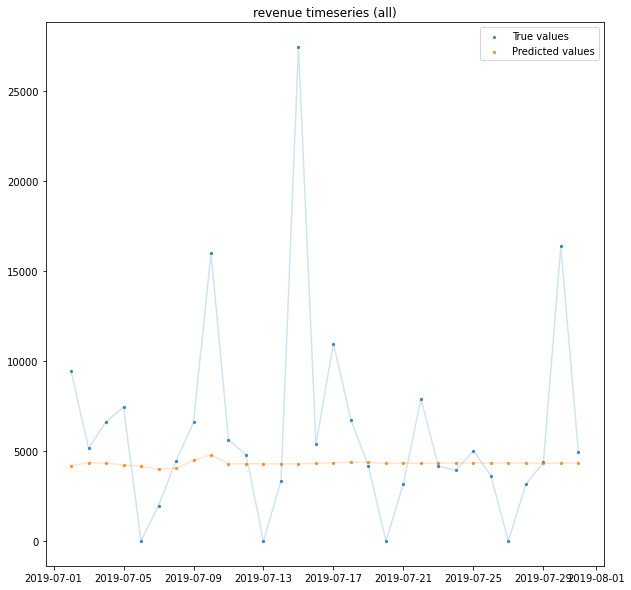

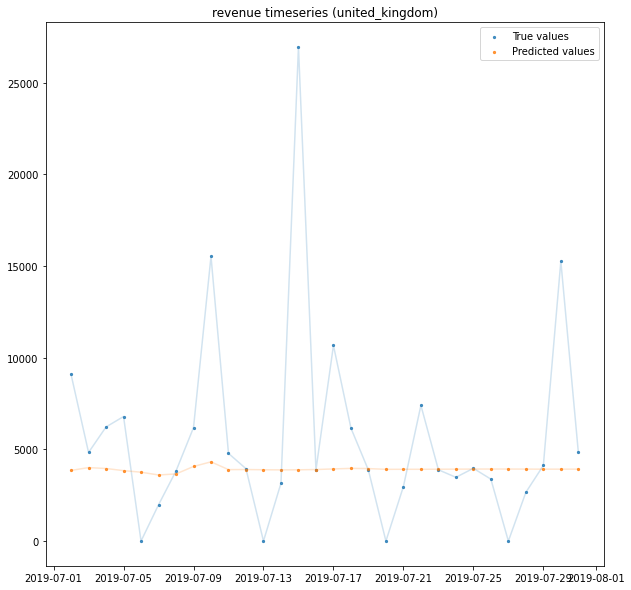

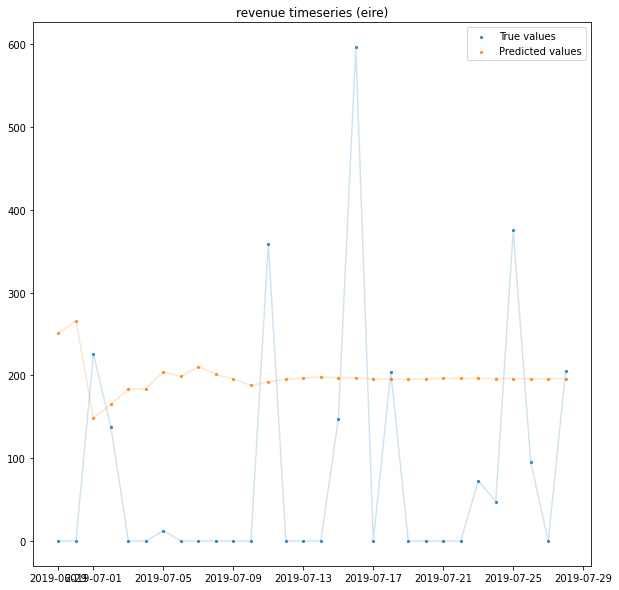

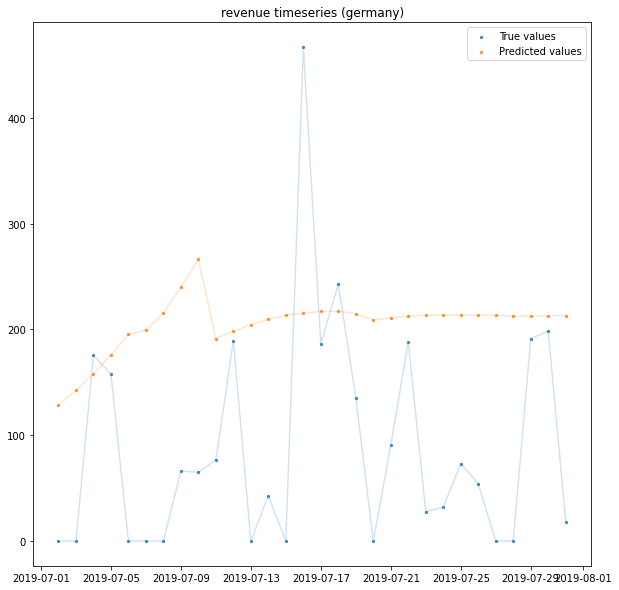

In [5]:
window = 9
keys = ['all', 'united_kingdom', 'eire', 'germany']
mae_ema = {}
y_pred = {}

for key in keys:
    df = ts_data[key].copy(deep=True)
    df_train = df[:-30]
    df_test = df[-30:].copy()
    
    y_pred[key] = df_train.revenue.values

    for date in df_test.date:
        y_pred[key] = np.append(y_pred[key], np.mean(y_pred[key][-window:]))

    # Exponential moving average to predict the next value.
    df_test['pred'] = df_train['revenue'].ewm(span=window).mean().iloc[-1]
    
    mae_ema[key] = mean_absolute_error(df_test.revenue, df_test.pred)
    
    ts_plot_pred(df.date.values[-30:], df.revenue.values[-30:],\
         df[-30:].date.values, y_pred[key][-30:], title="revenue timeseries ({})".format(key))

The predicted values line is relatively flat, making it useless for time series prediction.

## Prophet

We'll now try [FB Prophet](https://research.fb.com/prophet-forecasting-at-scale/), a time series forecasting tool open sourced by Facebook Research.

16:40:33 - cmdstanpy - INFO - Chain [1] start processing
16:40:33 - cmdstanpy - INFO - Chain [1] done processing
16:40:33 - cmdstanpy - INFO - Chain [1] start processing
16:40:33 - cmdstanpy - INFO - Chain [1] done processing
16:40:33 - cmdstanpy - INFO - Chain [1] start processing
16:40:34 - cmdstanpy - INFO - Chain [1] done processing
16:40:34 - cmdstanpy - INFO - Chain [1] start processing
16:40:34 - cmdstanpy - INFO - Chain [1] done processing


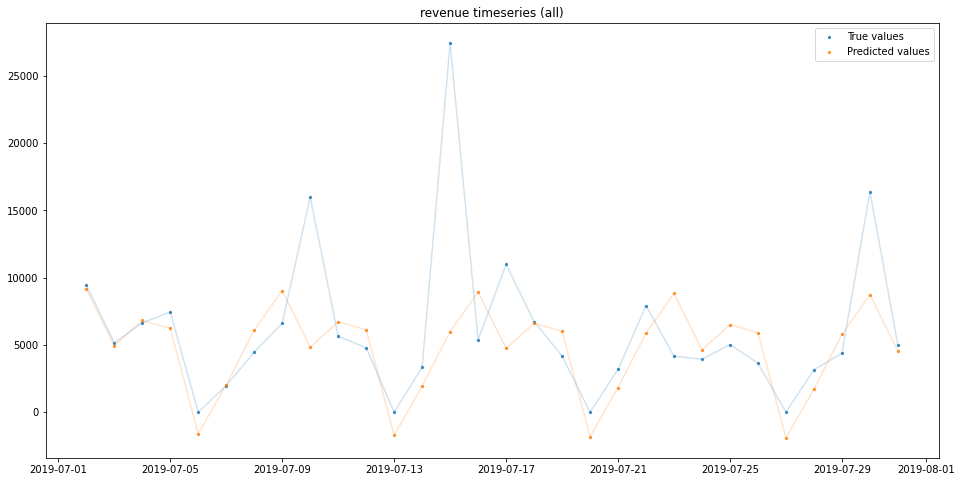

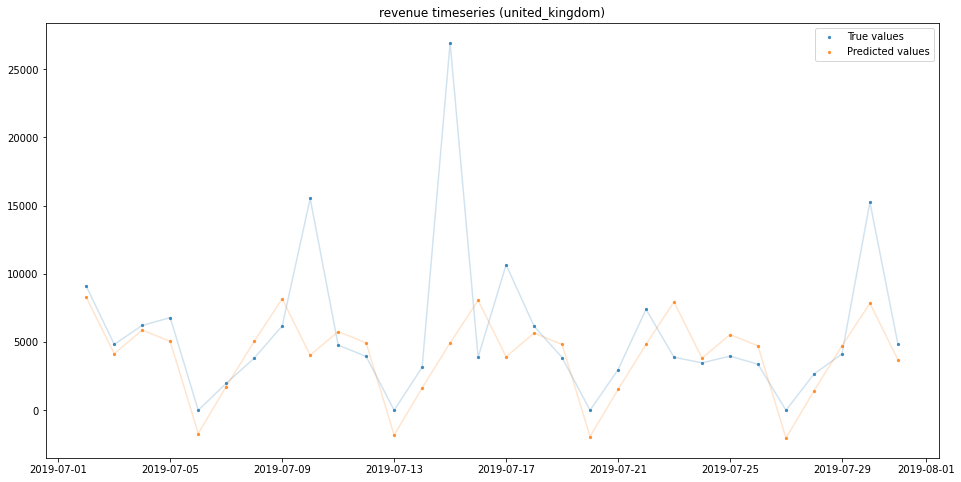

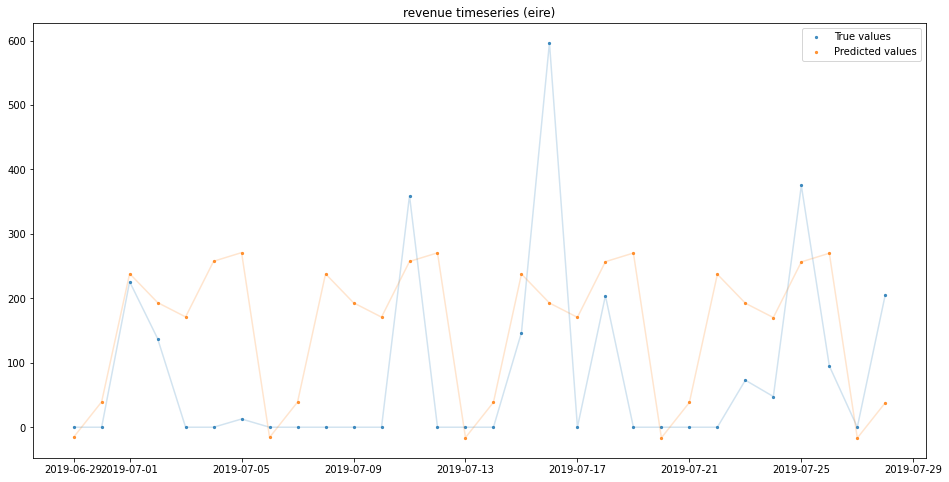

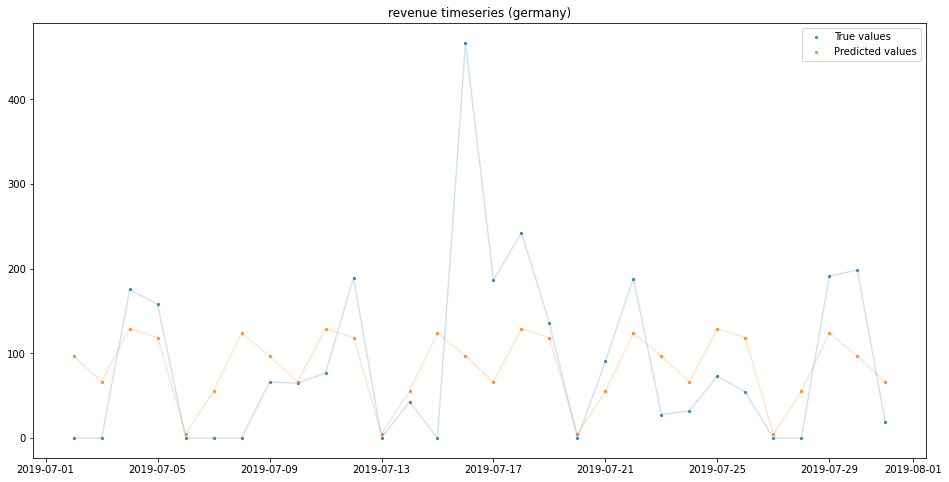

In [6]:
keys = ['all', 'united_kingdom', 'eire', 'germany']
y_pred = {}
mae_prophet = {}

for key in keys:
    df = ts_data[key][['date', 'revenue']].copy(deep=True)
    df.rename(columns={'date':'ds', 'revenue': 'y'},inplace=True)

    df_train = df[:-30]
    df_test = df[-30:]
    
    m = Prophet(weekly_seasonality=True)  
    m.fit(df_train)
    
    y_pred[key] = m.predict(df_test)
    
    mae_prophet[key] = mean_absolute_error(df_test.y, y_pred[key].yhat)
    
    ts_plot_pred(df.ds.values[-30:], df.y.values[-30:],\
             df[-30:].ds.values, y_pred[key][-30:].yhat.values, figx=16,figy=8, title=f"revenue timeseries ({key})")

In [7]:
for key in keys:
    if (mae_ema[key] > mae_prophet[key]):
        print("{}: prophet performed better than baseline ({} vs {})".format(key,mae_prophet[key],mae_ema[key]))
    else:
        print("{}: prophet performed worse than baseline ({} vs {})".format(key,mae_prophet[key],mae_ema[key]))

print()
print("Average MSE for baseline: {}".format(np.mean([val for _,val in mae_ema.items()])))
print("Average MSE for prophet: {}".format(np.mean([val for _,val in mae_prophet.items()])))

all: prophet performed better than baseline (2824.7543167121285 vs 3355.7310549678627)
united_kingdom: prophet performed better than baseline (2854.8346353219417 vs 3214.4492801626775)
eire: prophet performed better than baseline (129.82877451213085 vs 249.10905128571747)
germany: prophet performed better than baseline (65.1598229563724 vs 142.482465702837)

Average MSE for baseline: 1740.4429630297736
Average MSE for prophet: 1468.6443873756432


We see that Prophet performs better than the baseline for the 4 time series observed, making it a good candidate for production.

## Supervised learning model (Random Forest)

Let's try a supervised learning model, namely a Random Forest and XGBoost, for forecasting. Here we implement some feature engineering, such as information from the last 7 days.

d:\studying\ResFes\2024\ibm-ai-capstone\application\utils\processing.py:91: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mask = X.sum(axis=1)>0
d:\studying\ResFes\2024\ibm-ai-capstone\application\utils\processing.py:91: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mask = X.sum(axis=1)>0
d:\studying\ResFes\2024\ibm-ai-capstone\application\utils\processing.py:91: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mask = X.sum(axis=1)>0
d:\studying\ResFes\2024\ibm-ai-capstone\application\uti

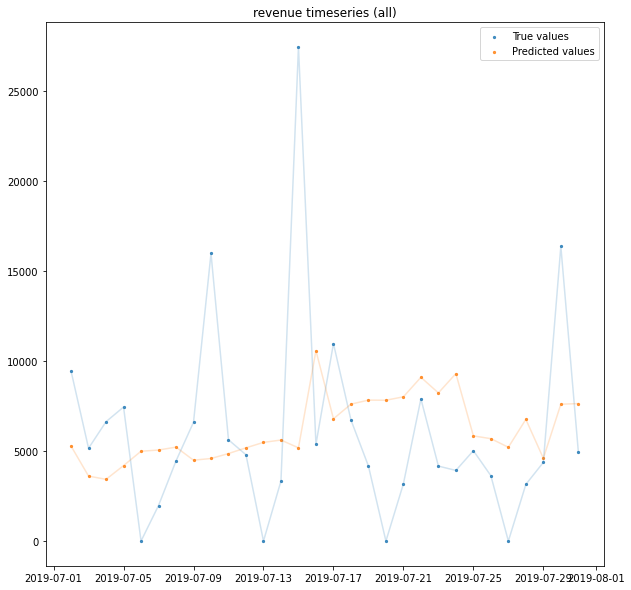

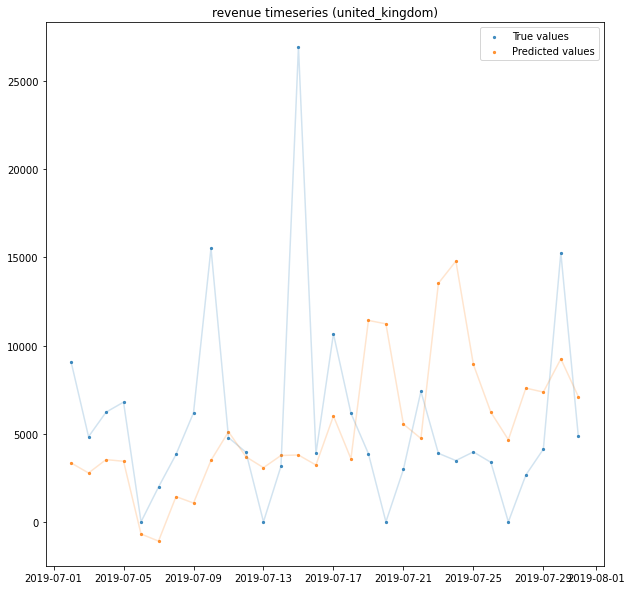

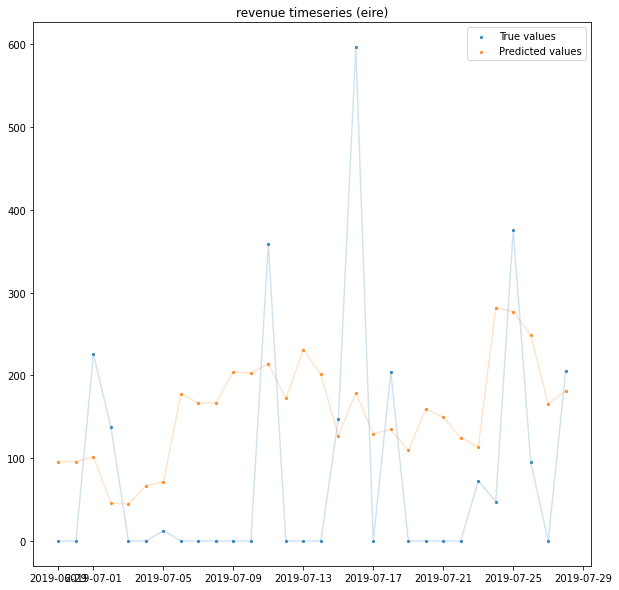

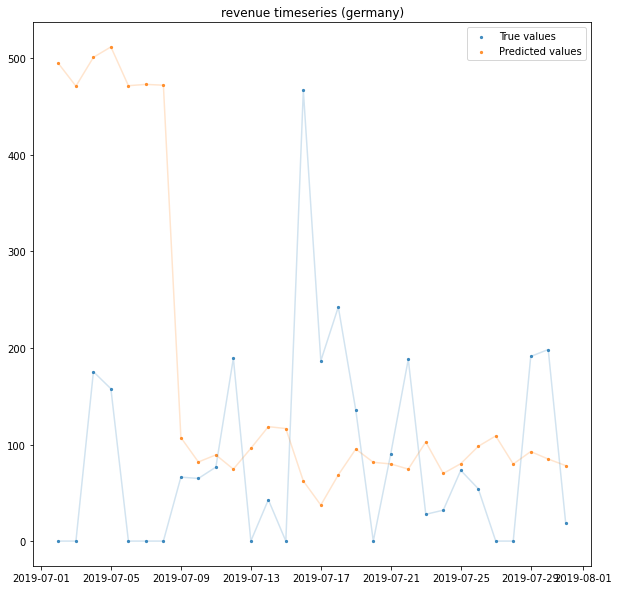

In [8]:
from sklearn.ensemble import RandomForestRegressor

keys = ['all', 'united_kingdom', 'eire', 'germany']
y_pred = {}
mae_rf = {}

for key in keys:
    df = ts_data[key]
    X,y,dates = engineer_features(df)

    X_train = X[:-30].drop(columns=['day'])
    X_test = X[-30:].drop(columns=['day'])
    y_train = y[:-30]
    y_test = y[-30:]
    
    rf = RandomForestRegressor()
    rf.fit(X_train,y_train)
    
    y_pred[key] = rf.predict(X_test)
    
    mae_rf[key] = mean_absolute_error(y_test, y_pred[key])
    
    ts_plot_pred(df.date.values[-30:], df.revenue.values[-30:],\
             df[-30:].date.values, y_pred[key][-30:], title=f"revenue timeseries ({key})")

In [9]:
for key in keys:
    if (mae_prophet[key] > mae_rf[key]):
        print(f"{key}: RF performed better than prophet ({mae_rf[key]} vs {mae_prophet[key]})")
    else:
        print(f"{key}: RF performed worse than prophet ({mae_rf[key]} vs {mae_prophet[key]})")

print()
print("Average MSE for RF: {}".format(np.mean([val for _,val in mae_rf.items()])))
print("Average MSE for prophet: {}".format(np.mean([val for _,val in mae_prophet.items()])))

all: RF performed worse than prophet (4210.138301333334 vs 2824.7543167121285)
united_kingdom: RF performed worse than prophet (4879.520207333333 vs 2854.8346353219417)
eire: RF performed worse than prophet (138.07598227777777 vs 129.82877451213085)
germany: RF performed worse than prophet (171.1568838888888 vs 65.1598229563724)

Average MSE for RF: 2349.7228437083336
Average MSE for prophet: 1468.6443873756432


### XGBoost

d:\studying\ResFes\2024\ibm-ai-capstone\application\utils\processing.py:91: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mask = X.sum(axis=1)>0
d:\studying\ResFes\2024\ibm-ai-capstone\application\utils\processing.py:91: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mask = X.sum(axis=1)>0
d:\studying\ResFes\2024\ibm-ai-capstone\application\utils\processing.py:91: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mask = X.sum(axis=1)>0
d:\studying\ResFes\2024\ibm-ai-capstone\application\uti

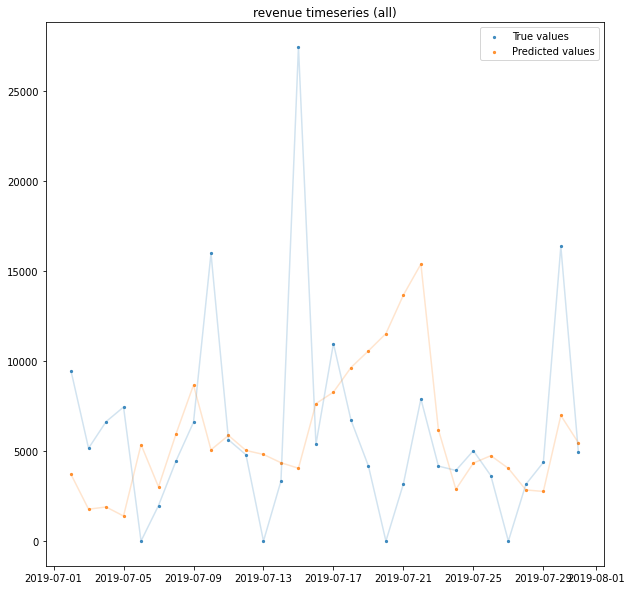

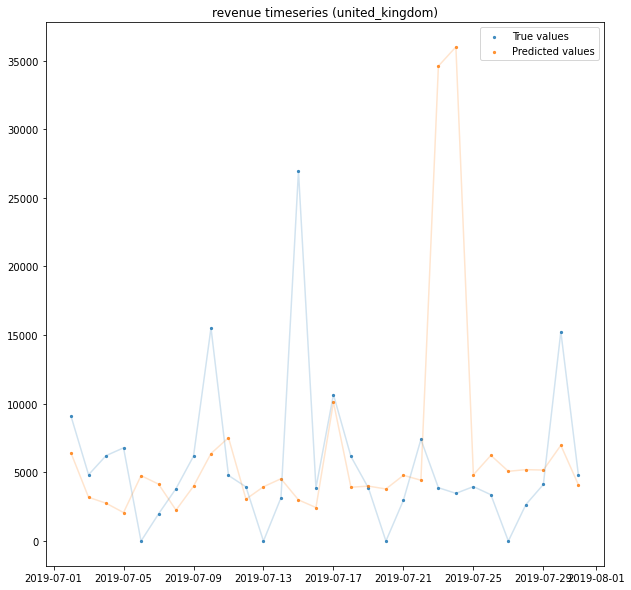

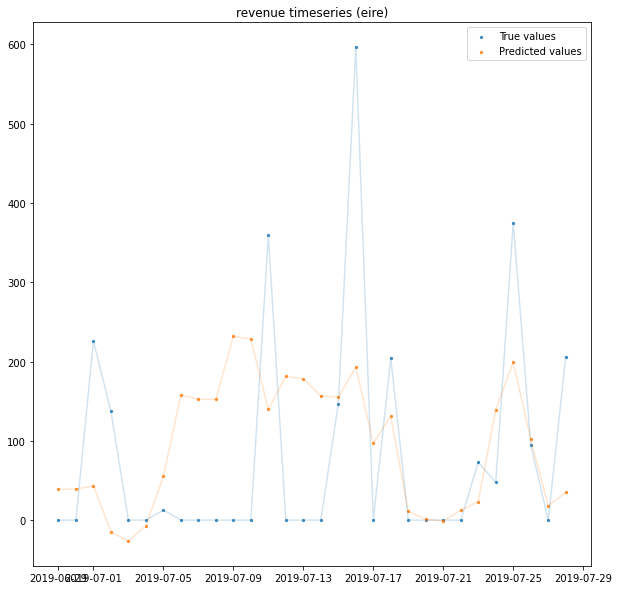

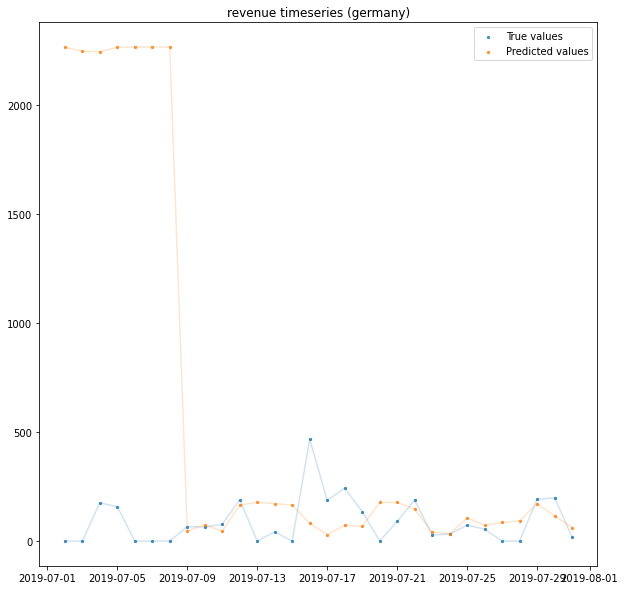

In [10]:
from xgboost import XGBRegressor

keys = ['all', 'united_kingdom', 'eire', 'germany']
y_pred = {}
mae_xg = {}

for key in keys:
    df = ts_data[key]
    X,y,dates = engineer_features(df)

    X_train = X[:-30].drop(columns=['day'])
    X_test = X[-30:].drop(columns=['day'])
    y_train = y[:-30]
    y_test = y[-30:]
    
    xg = XGBRegressor(n_estimators=400, max_depth=10)
    xg.fit(X_train,y_train)
    
    y_pred[key] = xg.predict(X_test)
    
    mae_xg[key] = mean_absolute_error(y_test, y_pred[key])
    
    ts_plot_pred(df.date.values[-30:], df.revenue.values[-30:],\
             df[-30:].date.values, y_pred[key][-30:], title=f"revenue timeseries ({key})")

In [11]:
for key in keys:
    if (mae_prophet[key] > mae_xg[key]):
        print(f"{key}: RF performed better than prophet ({mae_xg[key]} vs {mae_prophet[key]})")
    else:
        print(f"{key}: RF performed worse than prophet ({mae_xg[key]} vs {mae_prophet[key]})")

print()
print("Average MSE for RF: {}".format(np.mean([val for _,val in mae_xg.items()])))
print("Average MSE for prophet: {}".format(np.mean([val for _,val in mae_prophet.items()])))

all: RF performed worse than prophet (4501.251117708333 vs 2824.7543167121285)
united_kingdom: RF performed worse than prophet (5428.970403515626 vs 2854.8346353219417)
eire: RF performed better than prophet (108.92155255015693 vs 129.82877451213085)
germany: RF performed worse than prophet (583.5906190134684 vs 65.1598229563724)

Average MSE for RF: 2655.683423196896
Average MSE for prophet: 1468.6443873756432


XGBoost is right around Random Forest in terms of score.

## LSTM (Long-Short Term Memory)

We use Tensorflow for LSTM development. So we need some data processing.

In [12]:
import tensorflow as tf

def windowed_dataset(series, window_size=20, batch_size=32, shuffle_buffer=1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

d:\studying\ResFes\2024\ibm-ai-capstone\application\utils\processing.py:91: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mask = X.sum(axis=1)>0


Epoch 1/100
19/19 [==============================] - 6s 9ms/step - loss: 6741.9150 - mae: 6742.4126
Epoch 2/100
19/19 [==============================] - 0s 11ms/step - loss: 6204.9619 - mae: 6205.4619
Epoch 3/100
19/19 [==============================] - 0s 9ms/step - loss: 5015.5396 - mae: 5016.0396
Epoch 4/100
19/19 [==============================] - 0s 10ms/step - loss: 4655.6553 - mae: 4656.1553
Epoch 5/100
19/19 [==============================] - 0s 9ms/step - loss: 4592.5864 - mae: 4593.0859
Epoch 6/100
19/19 [==============================] - 0s 11ms/step - loss: 4584.1401 - mae: 4584.6392
Epoch 7/100
19/19 [==============================] - 0s 13ms/step - loss: 4584.9048 - mae: 4585.4043
Epoch 8/100
19/19 [==============================] - 0s 11ms/step - loss: 4579.5098 - mae: 4580.0088
Epoch 9/100
19/19 [==============================] - 0s 11ms/step - loss: 4580.3599 - mae: 4580.8589
Epoch 10/100
19/19 [==============================] - 0s 11ms/step - loss: 4578.0542 - mae: 45

ValueError: x and y must be the same size

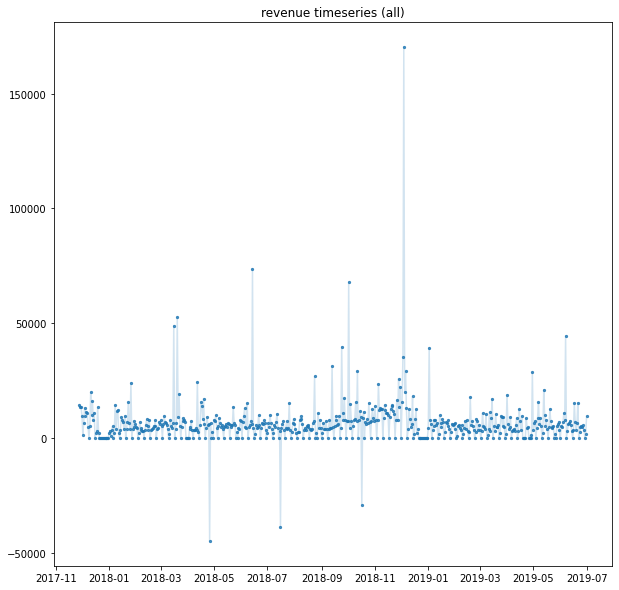

In [20]:
keys = ['all', 'united_kingdom', 'eire', 'germany']
y_pred = {}
mae_lstm = {}

for key in keys:
    df = ts_data[key]
    X,y,dates = engineer_features(df)

    X_train = X[:-30].drop(columns=['day'])
    X_test = X[-30:].drop(columns=['day'])
    y_train = y[:-30]
    y_test = y[-30:]
    
    lstm = tf.keras.models.Sequential([
        tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
        input_shape=[None]),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
        tf.keras.layers.Dense(32, activation="relu"),
        tf.keras.layers.Dense(1),
    ])

    lstm.compile(loss=tf.keras.losses.Huber(),
                  optimizer=tf.keras.optimizers.Adam(0.05),
                  metrics=["mae"])  

    lstm.fit(X_train, y_train, epochs=100)
    
    y_pred[key] = lstm.predict(X_test).flatten()
    
    mae_lstm[key] = mean_absolute_error(y_pred[key], y_test)
    
    ts_plot_pred(df.date.values[-30:], df.revenue.values[-30:],\
             df[-30:].date.values, y_pred[key][-30:], title=f"revenue timeseries ({key})")

## Comparison

We finish by comparing all MSEs obtained in a single plot. Below, you'll find the MSE comparison in normal scale and in log scale (due to the big difference in scale between the first two and the last two series). We can conclude that, among the models tested, Prophet shows the best performance, and should be chosen for production.

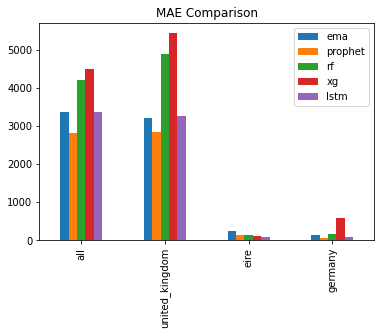

In [14]:
df_comparison = pd.DataFrame([mae_ema,mae_prophet,mae_rf, mae_xg, mae_lstm],index=['ema','prophet','rf','xg','lstm'])
_ = df_comparison.T.plot.bar(title="MAE Comparison")

Clearly Prophet is designed to handle time series like this! Let's bring it on to production!